Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from keras.layers import Dense, Dropout, Flatten
import glob

In [2]:
## Using the data by mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/gdrive/My Drive/Train")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/Test')

In [4]:
data_dir_train

PosixPath('/content/gdrive/My Drive/Train')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2259
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2259 files belonging to 9 classes.
Using 1808 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2259 files belonging to 9 classes.
Using 451 files for validation.


In [9]:
# Listing all the classes of skin cancer and storing them in a list in alphabetical order. 

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### visualizing one instance of all the nine classes present in the dataset

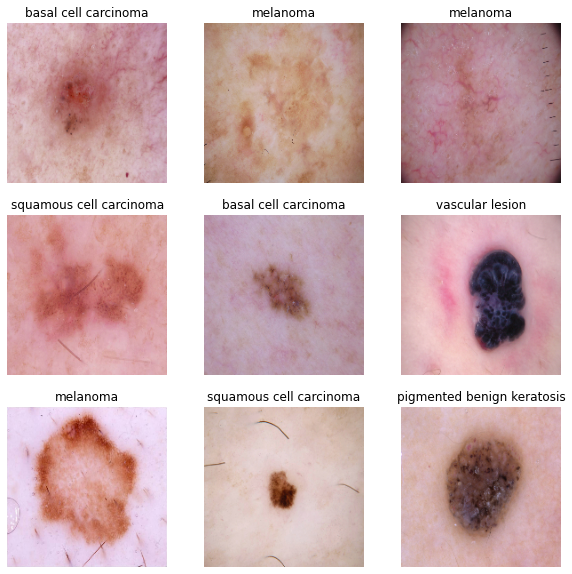

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Rescaling the values
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.89771235


In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])


In [14]:
### Choosing an 'adam' optimiser and 'SparseCategoricalCrossentropy' loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [16]:
#Training with 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


57/57 [==============================] - 54s 794ms/step - loss: 2.0501 - accuracy: 0.1908 - val_loss: 2.0436 - val_accuracy: 0.1951
Epoch 2/20
57/57 [==============================] - 3s 44ms/step - loss: 1.9160 - accuracy: 0.2832 - val_loss: 1.7753 - val_accuracy: 0.3592
Epoch 3/20
57/57 [==============================] - 2s 43ms/step - loss: 1.6829 - accuracy: 0.3861 - val_loss: 1.6215 - val_accuracy: 0.3991
Epoch 4/20
57/57 [==============================] - 2s 43ms/step - loss: 1.5227 - accuracy: 0.4491 - val_loss: 1.5257 - val_accuracy: 0.4324
Epoch 5/20
57/57 [==============================] - 2s 43ms/step - loss: 1.4392 - accuracy: 0.4912 - val_loss: 1.4159 - val_accuracy: 0.5011
Epoch 6/20
57/57 [==============================] - 2s 43ms/step - loss: 1.3695 - accuracy: 0.5227 - val_loss: 1.5232 - val_accuracy: 0.4878
Epoch 7/20
57/57 [==============================] - 2s 43ms/step - loss: 1.2918 - accuracy: 0.5531 - val_loss: 1.3916 - val_accuracy: 0.5166
Epoch 8/20
57/57 [====

### Visualizing training results

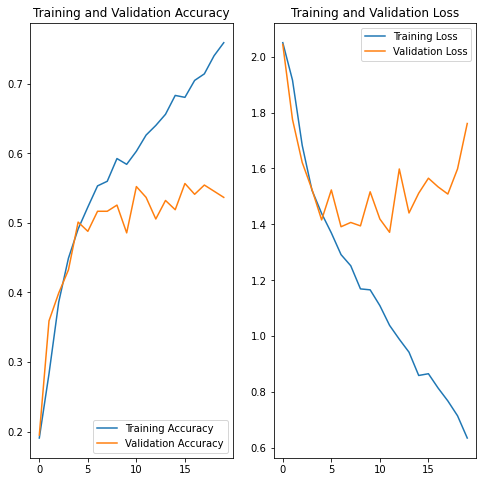

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write your findings here

#### The model is trained for 20 epochs

#### Clearely the model is over fitting, we can observe ther is a huge gap in the training and validation accuracy

#### we can see that the accuracy is above 80% for training and around 50-60% for the validation dataset

In [18]:
# choosing data augumentation strategy. 
data_augumentation = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

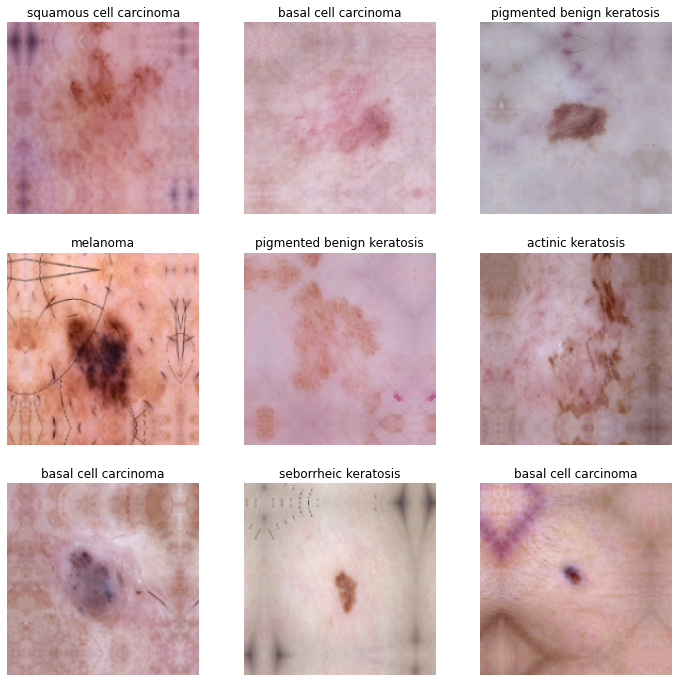

In [19]:
# visualizing how augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augumentation(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [20]:
## using Dropout layer to handel overfitting in model

model = Sequential([ data_augumentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])


### Compiling the model

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


### Training the model

In [23]:
## training model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


57/57 [==============================] - 5s 57ms/step - loss: 2.0159 - accuracy: 0.2367 - val_loss: 1.8924 - val_accuracy: 0.2882
Epoch 2/20
57/57 [==============================] - 3s 52ms/step - loss: 1.7968 - accuracy: 0.3435 - val_loss: 1.6930 - val_accuracy: 0.3880
Epoch 3/20
57/57 [==============================] - 3s 52ms/step - loss: 1.6660 - accuracy: 0.3877 - val_loss: 1.6502 - val_accuracy: 0.3769
Epoch 4/20
57/57 [==============================] - 3s 52ms/step - loss: 1.5702 - accuracy: 0.4292 - val_loss: 1.6023 - val_accuracy: 0.3880
Epoch 5/20
57/57 [==============================] - 3s 52ms/step - loss: 1.4821 - accuracy: 0.4718 - val_loss: 1.4568 - val_accuracy: 0.4701
Epoch 6/20
57/57 [==============================] - 3s 52ms/step - loss: 1.4106 - accuracy: 0.5105 - val_loss: 1.4492 - val_accuracy: 0.4789
Epoch 7/20
57/57 [==============================] - 3s 52ms/step - loss: 1.4193 - accuracy: 0.4945 - val_loss: 1.5159 - val_accuracy: 0.4257
Epoch 8/20
57/57 [======

### Visualizing the results

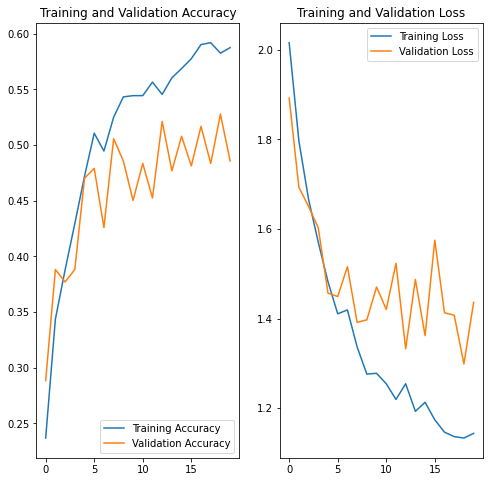

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### we can see that after adding data augmentation the overfitting problem has over come

#### but there is no much improvement in the overall model

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/My Drive/Train/actinic keratos...,actinic keratosis
1,/content/gdrive/My Drive/Train/actinic keratos...,actinic keratosis
2,/content/gdrive/My Drive/Train/actinic keratos...,actinic keratosis
3,/content/gdrive/My Drive/Train/actinic keratos...,actinic keratosis
4,/content/gdrive/My Drive/Train/actinic keratos...,actinic keratosis
...,...,...
2254,/content/gdrive/My Drive/Train/vascular lesion...,vascular lesion
2255,/content/gdrive/My Drive/Train/vascular lesion...,vascular lesion
2256,/content/gdrive/My Drive/Train/vascular lesion...,vascular lesion
2257,/content/gdrive/My Drive/Train/vascular lesion...,vascular lesion


In [26]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/My Drive/Train/actinic keratos...,actinic keratosis
1,/content/gdrive/My Drive/Train/actinic keratos...,actinic keratosis
2,/content/gdrive/My Drive/Train/actinic keratos...,actinic keratosis
3,/content/gdrive/My Drive/Train/actinic keratos...,actinic keratosis
4,/content/gdrive/My Drive/Train/actinic keratos...,actinic keratosis
...,...,...
2254,/content/gdrive/My Drive/Train/vascular lesion...,vascular lesion
2255,/content/gdrive/My Drive/Train/vascular lesion...,vascular lesion
2256,/content/gdrive/My Drive/Train/vascular lesion...,vascular lesion
2257,/content/gdrive/My Drive/Train/vascular lesion...,vascular lesion


<BarContainer object of 9 artists>

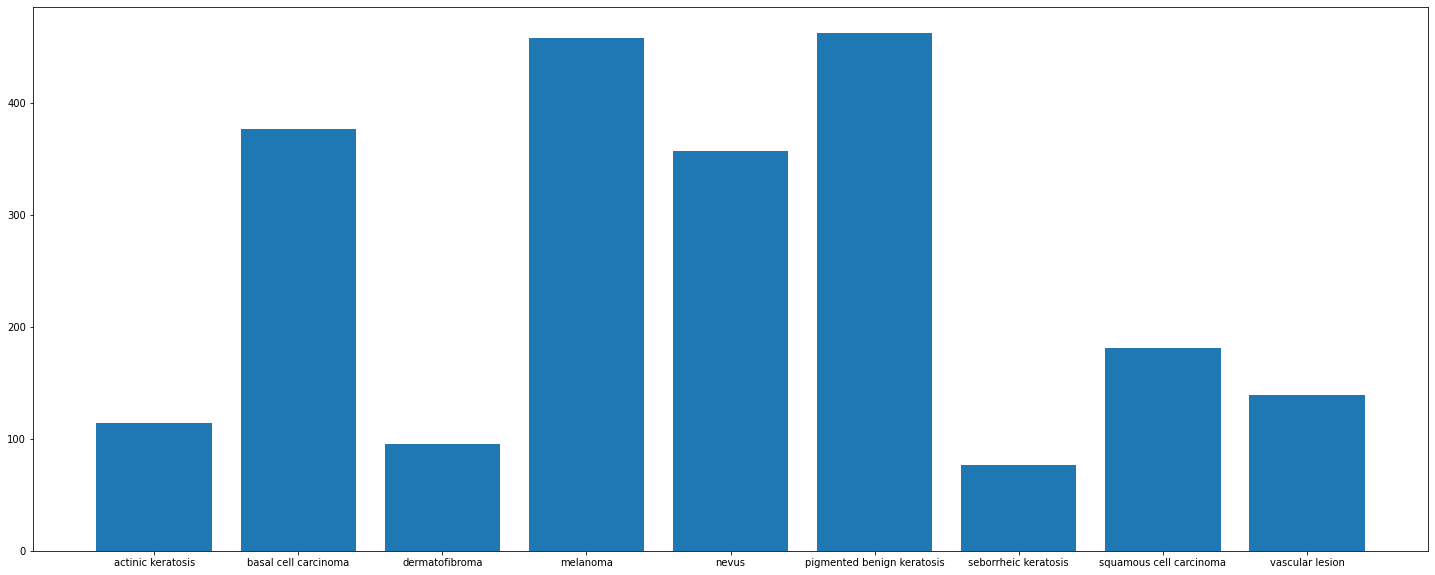

In [27]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)


## - Which class has the least number of samples?
#### Ans) As we can see from the plot that "Seborrheic keratosis" class has less samples

## - Which classes dominate the data in terms proportionate number of samples?
#### Ans) As we can see from the plot that "Pigmented benign keratosis" class has more samples

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [31]:
path_to_training_dataset="/content/gdrive/My Drive/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F504ABFB590>: 100%|██████████| 500/500 [00:22<00:00, 22.36 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F50475E02D0>: 100%|██████████| 500/500 [00:22<00:00, 22.12 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5049FA34D0>: 100%|██████████| 500/500 [00:22<00:00, 22.43 Samples/s]


Initialised with 458 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5047365B90>: 100%|██████████| 500/500 [01:35<00:00,  5.22 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F504AC73750>: 100%|██████████| 500/500 [01:39<00:00,  5.04 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F504AB02110>: 100%|██████████| 500/500 [00:21<00:00, 22.93 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F504ABE2950>: 100%|██████████| 500/500 [00:50<00:00,  9.84 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F50B0022110>: 100%|██████████| 500/500 [00:22<00:00, 22.42 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5047067DD0>: 100%|██████████| 500/500 [00:22<00:00, 22.46 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [41]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

AttributeError: ignored

### Lets see the distribution of augmented data after adding new images to the original training data.

In [42]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/My Drive/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027141.jpg_2a0daa0d-38a8-4de7-a3c4-f06c9c913e89.jpg',
 '/content/gdrive/My Drive/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026313.jpg_dd7a0620-c87a-41b9-b231-150609700b82.jpg',
 '/content/gdrive/My Drive/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025954.jpg_e2e15bb9-7a97-42d2-a7f5-2912d0fb19b0.jpg',
 '/content/gdrive/My Drive/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033675.jpg_6ef691e5-6dfb-4ec8-a987-99b93801196c.jpg',
 '/content/gdrive/My Drive/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027876.jpg_a9a265e5-c1b4-4939-ba07-a462b06a23ae.jpg',
 '/content/gdrive/My Drive/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027044.jpg_2abb1015-86d5-4fd8-a1c2-36481cca2672.jpg',
 '/content/gdrive/My Drive/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029578.jpg_4a126e28-edd5-4ba3-ac97-78db44541f17.jpg',
 '/content/gdrive/My Drive/

In [43]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [44]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [45]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [46]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      958
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [47]:
data_dir_train="/content/gdrive/My Drive/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 6759 files belonging to 9 classes.
Using 5408 files for training.


#### **Todo:** Create a validation dataset

In [48]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6759 files belonging to 9 classes.
Using 1351 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [49]:
model = Sequential([ data_augumentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [50]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [51]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 41s 225ms/step - loss: 1.7552 - accuracy: 0.3254 - val_loss: 1.5417 - val_accuracy: 0.4145
Epoch 2/30
169/169 [==============================] - 39s 221ms/step - loss: 1.5314 - accuracy: 0.4112 - val_loss: 1.4549 - val_accuracy: 0.4648
Epoch 3/30
169/169 [==============================] - 39s 223ms/step - loss: 1.4393 - accuracy: 0.4473 - val_loss: 1.3781 - val_accuracy: 0.4826
Epoch 4/30
169/169 [==============================] - 39s 223ms/step - loss: 1.3616 - accuracy: 0.4728 - val_loss: 1.2740 - val_accuracy: 0.5344
Epoch 5/30
169/169 [==============================] - 39s 223ms/step - loss: 1.2960 - accuracy: 0.4963 - val_loss: 1.3094 - val_accuracy: 0.5115
Epoch 6/30
169/169 [==============================] - 39s 223ms/step - loss: 1.2583 - accuracy: 0.5172 - val_loss: 1.2096 - val_accuracy: 0.5019
Epoch 7/30
169/169 [==============================] - 38s 221ms/step - loss: 1.2495 - accuracy: 0.5083 - val_loss: 1.3305 - val_accuracy: 0.5

#### **Todo:**  Visualize the model results

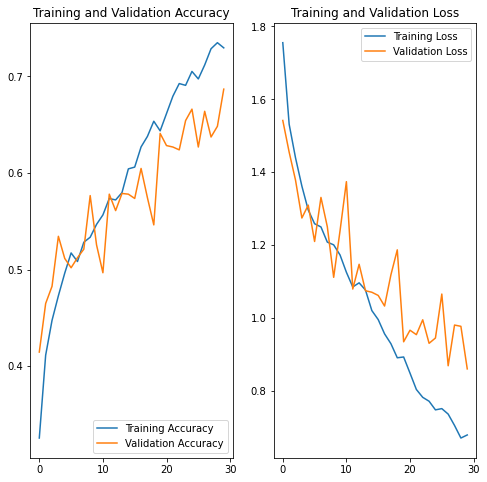

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Augmentator has helpes to increase the accuracy and also reduce the class imbalance

There is a decent accuracy in the model but it can still be improviced by adding more layers and testing with hyperparameter tuning
